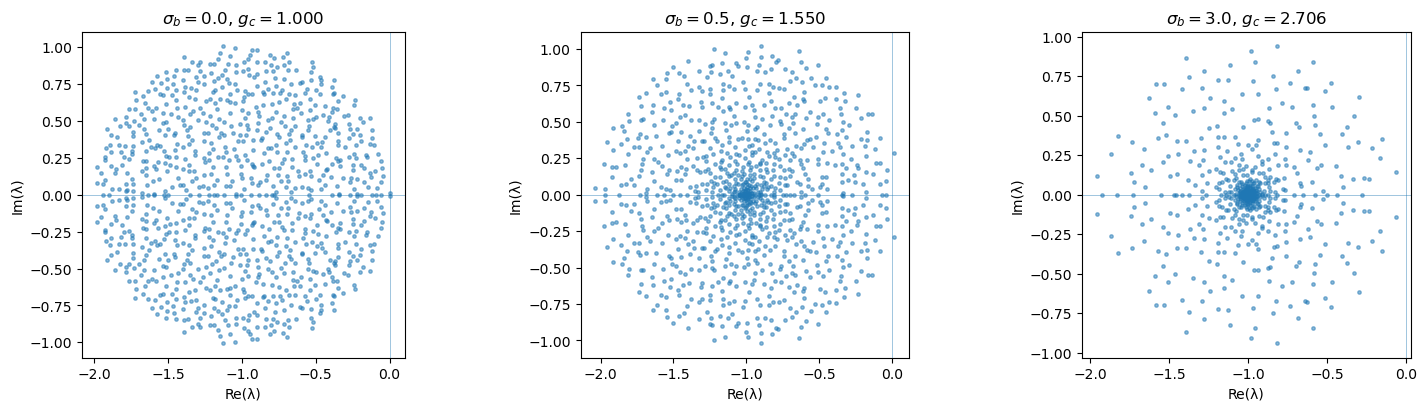

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import root_scalar


def phi_tanh(x):
    return np.tanh(x)

def dphi_tanh(x):
    t = np.tanh(x)
    return 1 - t * t


def make_J(N, seed=0):
    rng = np.random.RandomState(seed)
    return rng.randn(N, N) / np.sqrt(N)

def make_bias(N, sigma=0.03, seed=1):
    rng = np.random.RandomState(seed)
    return sigma * rng.randn(N)

def make_x0(N, scale=0.1, seed=2):
    rng = np.random.RandomState(seed)
    return scale * rng.randn(N)


def step(x, J, g, tau, dt, I):
    ph = np.tanh(x)
    return x + dt * ((-x + g * (J @ ph) + I) / tau)


def compute_trajectory(J, I, g, tau, dt, T, warmup, x0, stride=1):
    warm = int(np.round(warmup / dt))
    sim = int(np.round(T / dt))
    x = x0.copy()
    t = 0.0

    for _ in range(warm):
        x = step(x, J, g, tau, dt, I)
        t += dt

    S = sim // stride
    X = np.empty((S, J.shape[0]))
    ts = np.empty(S)
    k = 0

    for s in range(sim):
        x = step(x, J, g, tau, dt, I)
        t += dt
        if (s + 1) % stride == 0:
            X[k] = x
            ts[k] = t
            k += 1
    return X, ts


def stable_sech(x):
    return 2 * np.exp(-np.abs(x)) / (1 + np.exp(-2 * np.abs(x)))

def gaussian_integral(f, sigma=1):
    phi = lambda x: np.exp(-x**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    val, _ = quad(lambda x: f(x) * phi(x), -np.inf, np.inf, epsabs=1e-10, epsrel=1e-10)
    return val

def equation(C0, sigma_b):
    r = np.sqrt(C0)
    num = gaussian_integral(lambda z: np.tanh(r * z)**2)
    den = gaussian_integral(lambda z: stable_sech(r * z)**4)
    return C0 - num / den - sigma_b**2


sigma_b_values = [0, 0.5, 3]
g_c = []

for sb in sigma_b_values:
    if sb == 0:
        g_c.append(1)
    else:
        sol = root_scalar(lambda C0: equation(C0, sb), bracket=[1e-8, 50], method='brentq', xtol=1e-8)
        C0 = sol.root
        den = gaussian_integral(lambda x: stable_sech(np.sqrt(C0) * x)**4)
        g_c.append(1 / np.sqrt(den))


sigma_b_values = [0, 0.5, 3]
g_c_values = g_c

N = 1000
tau = 1.0
T = 500
dt = 1
warmup = 200

J = make_J(N, seed=0)
I0 = make_bias(N, sigma=1, seed=1)
x0 = make_x0(N, scale=0.1, seed=2)

eigvals_list = []
labels = []

for sb, g in zip(sigma_b_values, g_c_values):
    I = sb * I0
    Xs, ts = compute_trajectory(J, I, g, tau, dt, T, warmup, x0)

    k = min(10, Xs.shape[0])
    fp = Xs[-k:].mean(axis=0)

    sech2 = 1 / (np.cosh(fp)**2)
    Jb = -np.eye(N) + g * (J * sech2[np.newaxis, :])

    eig = np.linalg.eigvals(Jb)
    eigvals_list.append(eig)
    labels.append(f'σ_b={sb}, g_c={g:.3f}')


fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
for ax, ev, lab in zip(axes, eigvals_list, labels):
    ax.scatter(ev.real, ev.imag, s=6, alpha=0.5)
    ax.set_title(lab)
    ax.set_xlabel('Re(λ)')
    ax.set_ylabel('Im(λ)')
    ax.axhline(0, lw=0.5, alpha=0.6)
    ax.axvline(0, lw=0.5, alpha=0.6)
    ax.set_aspect('equal')

plt.show()

